# Addition Problem

Given a sequence of numbers, remember the two numbers that are marked, and calculate their sum.

At each timestep, the inputs are two numbers: some random number and a binary marker. The binary marker is true for a total of two numbers in the sequence. After the sequenc e(when the binary marker is -1) output the sum of the two marked numbers.

This is almost identical to one of the benchmark problems in the original LSTM paper.

In [1]:
import numpy as np
from binet import op
from binet import NeuralNet
from binet.util import train
from binet.lstm import LongShortTermMemoryLayer
from binet.layers import BasicLayer

In [2]:
def generate_addition_problem_samples(n_seqs, seq_len, dtype=np.float32):
    X = np.ones((n_seqs, seq_len, 2), dtype=dtype)
    T = np.empty((n_seqs, 1), dtype=dtype)
    for i in range(n_seqs):
        X[i, :, 0] = np.random.uniform(-1, 1, size=seq_len).astype(dtype)
        m = np.zeros(seq_len, dtype=np.float32)
        m[np.random.randint(1, 10)] = 1
        m[np.random.randint(10, seq_len/2)] = 1
        m[-1] = -1  ### mark the end of the sequence
        X[i, :, 1] = m
        T[i] = X[i, :, 0][m == 1].sum() 
    return X, T

In [3]:
batch_size = 128
seq_len = 100
X, T = generate_addition_problem_samples(batch_size*100, seq_len)

X.shape, T.shape

((12800, 100, 2), (12800, 1))

In [7]:
import time
import copy
from binet.util import generate_slices
from binet import op

#op.init_gpu(2)

seq_len = 100
eta = 0.05
batch_size = 128
n_iter = 10
n_hiddens = 4
n_input_features = 2

l = LongShortTermMemoryLayer(n_hiddens, has_forgetgate=False)
o = BasicLayer(1, activation='linear')

X, T = generate_addition_problem_samples(batch_size*1000, seq_len)
D = np.zeros((seq_len, batch_size, l.size), dtype=l.dtype)

l.setup((seq_len, n_input_features), batch_size)
o.setup(n_hiddens, batch_size)

#X, T, l, W, b, D = [op.to_gpu(tmp) for tmp in (X, T, l, W, b, D)]

lstm_list = []
err = []
t0 = time.time()
for cur_iter in range(n_iter):
    for s in generate_slices(X.shape[0], l.batch_size):
        A = l.fprop(X[s])
        Y = o.fprop(A)
        delta = Y - T[s]
        err.append(op.sum(delta**2))
        D[-1] = o.bprop(delta)
        l.bprop(D)
        l.update(eta)
        o.update(eta)
    #if cur_iter % 1000 == 0:
    #lstm_list.append(copy.deepcopy(op.to_numpy(l)))
    t1 = time.time() - t0
    print("%5d: %6.3f  (%3.2fs)" % (cur_iter, op.to_cpu(err[-1]), t1), flush=True)

    0: 85.538  (36.65s)
    1: 80.185  (73.71s)
    2: 74.839  (110.84s)
    3: 30.170  (147.90s)
    4: 10.958  (185.06s)
    5:  6.760  (222.27s)
    6:  4.706  (259.46s)
    7:  3.493  (295.20s)
    8:  2.724  (332.57s)
    9:  2.215  (369.73s)


Using matplotlib backend: TkAgg


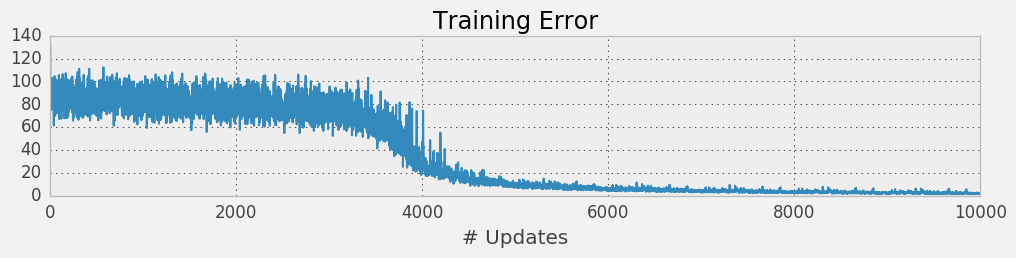

In [8]:
%matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(err)
ax.set_xlabel("# Updates")
ax.set_title("Training Error")
fig

# System Information

In [1]:
from binet import print_system_information
print_system_information()

Host:                k40: Linux-3.10.0-229.14.1.el7.x86_64-x86_64-with-centos-7.1.1503-Core
Date:                2015-11-17 13:18:53.651821
Python version:      3.4.3 (default, Mar  1 2015, 13:48:33) 
                     [GCC 4.8.2 20140120 (Red Hat 4.8.2-16)]
repository version:  commit 023fd2e8053be893c438a9cbaf4f01b32caa31c3

loaded modules:
	 IPython 4.0.0
	 binet 2015.11
	 matplotlib 1.5.0
	 numpy 1.10.1
	 pandas 0.17.0
	 scipy 0.16.0
	 sklearn 0.17
